# Statistical Programming Project 2

# Introduction
There are two datasets, 'games' and 'teams', that I am using which were taken from <a href = 'https://www.kaggle.com/datasets/nathanlauga/nba-games?select=teams.csv'>Kaggle</a>. Dataset 'games' has 21 columns containing information about number of points, assists, rebounds, field goal percentage, three point percentage, freethrow percentage for each team: home and visitor; from 2004 to 2021. Dataset 'teams' has 14 columns from which only 2 will be useful: TEAM_ID and NICKNAME of the team. So, we should get rid of useless columns. 


---


In this project, I investigated how well we can predict home team wins taking into account number of assists, rebounds, field goal percentage, three point percentage, freethrow percentage of both home and away teams. My motivation is I wanted to know if analytics could predict outcome of the match in the middle of the game. Under assumption that there is no big difference in statistics between first half and second half, this is a reasonably good question. 


---
Three classifiers that we covered were used in this project: K-Nearest Neighbors, Decision Tree, and Random Forest. Since they are all non-parametric feature pre-processing is not needed.


# Experiments

## Data Preparation

In [ ]:
# from project 1
import pandas as pd
games = pd.read_csv(r'https://raw.githubusercontent.com/sergazyyeev/stat_prog_project1/main/games.csv')
teams = pd.read_csv(r'https://raw.githubusercontent.com/sergazyyeev/stat_prog_project1/main/teams.csv')
teams = teams[['NICKNAME', 'TEAM_ID']]
games.drop(['GAME_ID', 'TEAM_ID_home', 'TEAM_ID_away', 'GAME_DATE_EST', 'GAME_STATUS_TEXT'], axis = 1, inplace = True)
games = games.rename(columns = {'HOME_TEAM_ID' : 'TEAM_ID'})
games_temp = pd.merge(games, teams, how = 'left', on = 'TEAM_ID')
games_temp.TEAM_ID = games_temp.NICKNAME
games_temp.drop('NICKNAME', axis = 1, inplace = True)
games_temp = games_temp.rename(columns = {'TEAM_ID' : 'HOME_TEAM'})
games_temp = games_temp.rename(columns = {'VISITOR_TEAM_ID' : 'TEAM_ID'})
data = pd.merge(games_temp, teams, how = 'left', on = 'TEAM_ID')
data.TEAM_ID = data.NICKNAME
data.drop('NICKNAME', axis = 1, inplace = True)
data = data.rename(columns = {'TEAM_ID' : 'VISITOR_TEAM'})
data = data.dropna()
data.head()

,HOME_TEAM,VISITOR_TEAM,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,Heat,Timberwolves,2021,104.0,0.398,0.760,0.333,23.0,53.0,113.0,0.422,0.875,0.357,21.0,46.0,0
1,Bulls,Cavaliers,2021,101.0,0.443,0.933,0.429,20.0,46.0,91.0,0.419,0.824,0.208,19.0,40.0,1
2,Spurs,Pacers,2021,108.0,0.412,0.813,0.324,28.0,52.0,119.0,0.489,1.000,0.389,23.0,47.0,0
3,Warriors,Bucks,2021,122.0,0.484,0.933,0.400,33.0,55.0,109.0,0.413,0.696,0.386,27.0,39.0,1
4,Nuggets,Raptors,2021,115.0,0.551,0.750,0.407,32.0,39.0,127.0,0.471,0.760,0.387,28.0,50.0,0


In [ ]:
# data for ML models
data_for_ml = data[['FG_PCT_home', 'FT_PCT_home', 'AST_home', 'REB_home', 
                    'FG_PCT_away', 'FT_PCT_away', 'AST_away', 'REB_away',
                    'HOME_TEAM_WINS']]
X = data_for_ml.drop('HOME_TEAM_WINS', axis = 1)
y = data_for_ml['HOME_TEAM_WINS']


In [ ]:
# train-valid-test split 80:10:10
from sklearn.model_selection import train_test_split
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_valid, X_test, y_valid, y_test = train_test_split(X_other, y_other, test_size = 0.5, random_state = 0)

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_valid_pred = knn.predict(X_valid)
print('Accuracy score is', metrics.accuracy_score(y_valid_pred, y_valid))

Accuracy score is 0.7163424124513619


In [ ]:
# tuning
acc_scores_valid = []
for i in range(1,50):
  knn = KNeighborsClassifier(n_neighbors = i)
  knn.fit(X_train, y_train)
  y_valid_pred = knn.predict(X_valid)
  acc_scores_valid.append(metrics.accuracy_score(y_valid_pred, y_valid))
for i in range(49):
  if max(acc_scores_valid) == acc_scores_valid[i]:
    print('Maximum accuracy score',max(acc_scores_valid),'is obtained when number of neighbors is', i)

Maximum accuracy score 0.7455252918287938 is obtained when number of neighbors is 20


In [ ]:
# train and validation sets combined to train more
X_combined = X_train.append(X_valid)
y_combined = y_train.append(y_valid)

In [ ]:
# accuracy of test set
knn = KNeighborsClassifier(n_neighbors = 20)
knn.fit(X_combined, y_combined)
y_test_pred = knn.predict(X_test)
knn_acc_score = metrics.accuracy_score(y_test_pred, y_test)
print('Accuracy on test set is', knn_acc_score)

Accuracy on test set is 0.7396887159533074


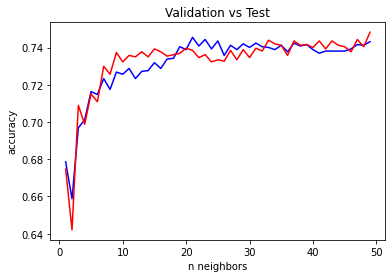

In [ ]:
# validation vs test
acc_scores_test = []
for i in range(1,50):
  knn = KNeighborsClassifier(n_neighbors = i)
  knn.fit(X_combined, y_combined)
  y_test_pred = knn.predict(X_test)
  acc_scores_test.append(metrics.accuracy_score(y_test_pred, y_test))

import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(1,50), acc_scores_valid, color = 'blue')
plt.plot(np.arange(1,50), acc_scores_test, color = 'red')
plt.xlabel('n neighbors')
plt.ylabel('accuracy')
plt.title('Validation vs Test')
plt.show()

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth = 3, random_state = 0)
dtree.fit(X_train, y_train)
y_valid_pred = dtree.predict(X_valid)
metrics.accuracy_score(y_valid_pred, y_valid)

0.7797665369649806

In [ ]:
# tuning
acc_scores_valid = []
for i in range(1,30):
  dtree = DecisionTreeClassifier(max_depth = i, random_state = 0)
  dtree.fit(X_train, y_train)
  y_valid_pred = dtree.predict(X_valid)
  acc_scores_valid.append(metrics.accuracy_score(y_valid_pred, y_valid))
for i in range(29):
  if max(acc_scores_valid) == acc_scores_valid[i]:
    print('Maximum accuracy of',max(acc_scores_valid),'occurs when max depth is', i + 1)

Maximum accuracy of 0.8019455252918288 occurs when max depth is 9


In [ ]:
# accuracy of test set
dtree = DecisionTreeClassifier(max_depth = 9)
dtree.fit(X_combined, y_combined)
y_test_pred = dtree.predict(X_test)
dt_acc_score = metrics.accuracy_score(y_test_pred, y_test)
print('Accuracy on test set is', dt_acc_score)

Accuracy on test set is 0.7910505836575875


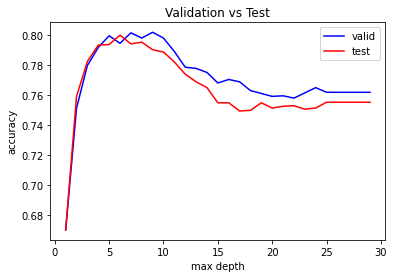

In [ ]:
# validation vs test
acc_scores_test = []
for i in range(1,30):
  dtree = DecisionTreeClassifier(max_depth = i, random_state = 0)
  dtree.fit(X_combined, y_combined)
  y_test_pred = dtree.predict(X_test)
  acc_scores_test.append(metrics.accuracy_score(y_test_pred, y_test))

plt.plot(np.arange(1,30), acc_scores_valid, color = 'blue', label = 'valid')
plt.plot(np.arange(1,30), acc_scores_test, color = 'red', label = 'test')
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('Validation vs Test')
plt.legend()
plt.show()

## Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier(n_estimators = 100, random_state = 0)
rforest.fit(X_train, y_train)
y_valid_pred = rforest.predict(X_valid)
metrics.accuracy_score(y_valid_pred, y_valid)

0.8268482490272373

In [ ]:
# tuning
acc_scores_valid = []
for i in range(50, 250, 10):
  rforest = RandomForestClassifier(n_estimators = i, random_state = 0)
  rforest.fit(X_train, y_train)
  y_valid_pred = rforest.predict(X_valid)
  acc_scores_valid.append(metrics.accuracy_score(y_valid_pred, y_valid))
for i in range(len(acc_scores_valid)):
  if max(acc_scores_valid) == acc_scores_valid[i]:
    print('Maximum accuracy of',max(acc_scores_valid),'occurs when number of estimators is', i*10 + 50)

Maximum accuracy of 0.8295719844357977 occurs when number of estimators is 130


In [ ]:
# accuracy of test set
rforest = RandomForestClassifier(n_estimators = 130, random_state = 0)
rforest.fit(X_combined, y_combined)
y_test_pred = rforest.predict(X_test)
rf_acc_score = metrics.accuracy_score(y_test_pred, y_test)
print('Accuracy on test set is', rf_acc_score)

Accuracy on test set is 0.830739299610895


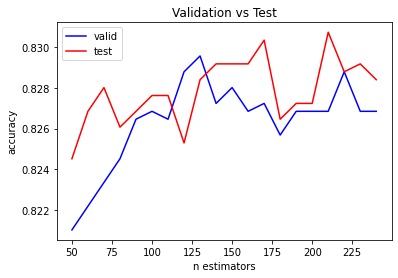

In [ ]:
# validation vs test
acc_scores_test = []
for i in range(50,250,10):
  rforest = RandomForestClassifier(n_estimators = i, random_state = 0)
  rforest.fit(X_combined, y_combined)
  y_test_pred = rforest.predict(X_test)
  acc_scores_test.append(metrics.accuracy_score(y_test_pred, y_test))

plt.plot(np.arange(50,250,10), acc_scores_valid, color = 'blue', label = 'valid')
plt.plot(np.arange(50,250,10), acc_scores_test, color = 'red', label = 'test')
plt.xlabel('n estimators')
plt.ylabel('accuracy')
plt.title('Validation vs Test')
plt.legend()
plt.show()

# Analysis and Discussion

In [ ]:
print("{:<8}    {:<10} ".format('Classifier','Accuracy score'))
print("{:<8}      {:<15} ".format('KNN', knn_acc_score))
print("{:<8} {:<15} ".format('Decision Tree', dt_acc_score))
print("{:<8} {:<15} ".format('Random Forest', rf_acc_score))

Classifier    Accuracy score 
KNN           0.7396887159533074 
Decision Tree 0.7910505836575875 
Random Forest 0.830739299610895 


In [ ]:
# proportion of home team wins
sum(data_for_ml.HOME_TEAM_WINS == 1)/len(data_for_ml)

0.5897575592481613

KNN performs worse than other classifiers on the new dataset because it is less flexible in terms of learning. It memorizes the whole training dataset and applies fitted structure to unseen dataset. Decision Tree has automatic feature interaction. Also, data is not perfectly balanced (60/40). Therefore KNN has less accurate results. Decision Tree is more robust to unbalanced data. Random Forest performs better because it consists of decision trees under optimal hyperparameters. \\
I tuned classifiers using only one hyperparameter in each case: KNN is tuned by number of neighbors, Decision Tree is tuned by maximum level of depth, and Random Forest is tuned by number of estimators.

# Conclusion
To conclude, Random Forest provides more accurate results (about 83%) in prediction of home team wins in the NBA league compared to K-Nearest Neighbors (74%) and Decision Tree classifiers (79%). Single hyperparameters were used to tune classifiers. In further work, more hyperparameters should be investigated to enhance the performance of classifiers. Also, to check how well classifiers generalize I would take new statistics obtained from 2022 playoff games. 